# Step 1: Brief description of the problem and data

This is a binary image classification problem where I will look at images to determine if they contain cancer or not.  The data used came from the competition, Histopathologic Cancer Detection.

In [2]:
# import packages
from numpy.random import seed
seed(101)
import tensorflow as tf
tf.random.set_seed(1)

import pandas as pd
import numpy as np
import seaborn as sns

from tensorflow import keras
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation, BatchNormalization
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.optimizers import SGD#Adam

import os
import cv2

from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
import itertools
import shutil
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

In [3]:
# load data
test_path = '../input/histopathologic-cancer-detection/test/'
train_path = '../input/histopathologic-cancer-detection/train/'
sample_submission = pd.read_csv('../input/histopathologic-cancer-detection/sample_submission.csv')
train_df = pd.read_csv('../input/histopathologic-cancer-detection/train_labels.csv')

In [4]:
# initializing the internal random number generator
RANDOM_STATE = 49

# Step 2: Exploratory Data Analysis (EDA) - Inspect, Visualize and Clean the Data

In [5]:
# viewing the first 5 records of the train data
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


<AxesSubplot:>

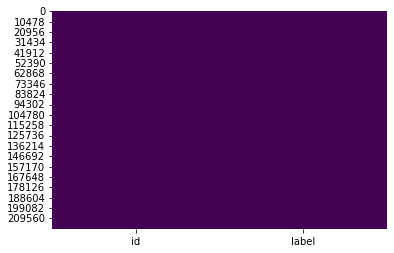

In [6]:
# check for missing data
sns.heatmap(train_df.isnull(),cbar=False,cmap='viridis')

As seen in the heatmap above, I am showing no issues of missing data.

In [7]:
# looking at the statistics for the train data set
train_df.describe()

,label
count,220025.000000
mean,0.405031
std,0.490899
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


In [8]:
# looking at data types, I see that the label column is an integer data type.  I will have to convert this later.
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 220025 entries, 0 to 220024
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   id      220025 non-null  object
 1   label   220025 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 3.4+ MB


<AxesSubplot:xlabel='count', ylabel='label'>

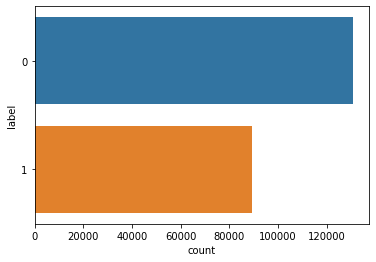

In [9]:
#bar chart to see the number of images that have cancer vs number of images that do not
sns.countplot(y='label', data = train_df)

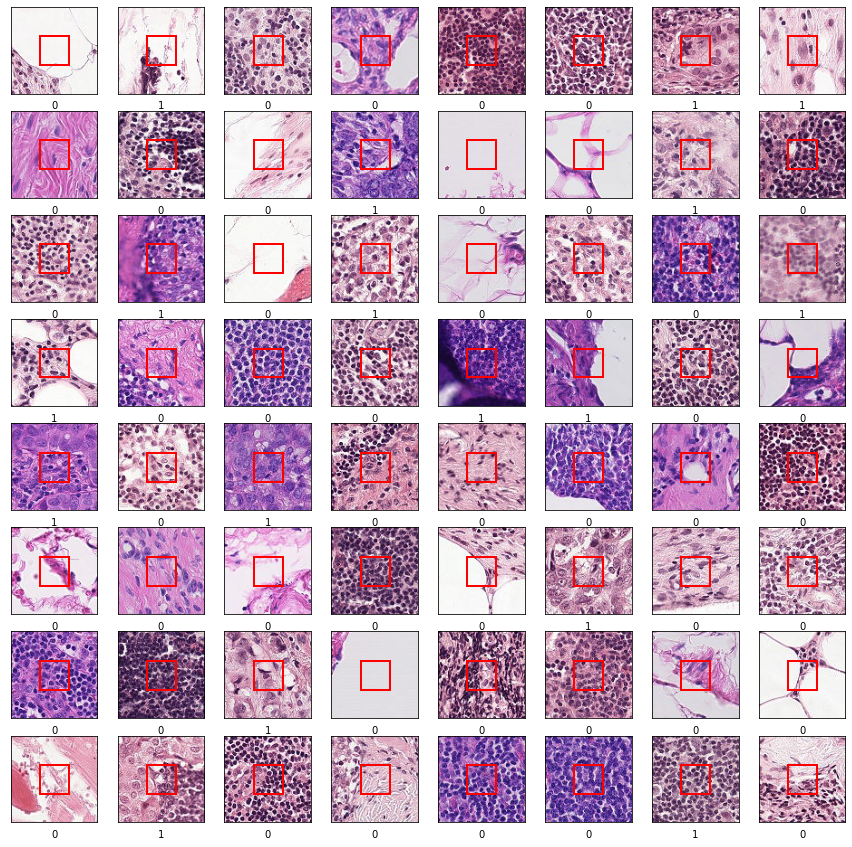

In [10]:
#viewing images to see which ones have cancer and which do not
from skimage import io
import matplotlib.patches as patches

fig, ax = plt.subplots(8, 8, figsize=(15, 15))
for i, axis in enumerate(ax.flat):
    file = str(train_path + train_df.id[i] + '.tif')
    image = io.imread(file)
    axis.imshow(image)
    box = patches.Rectangle((32,32),32,32, linewidth=2, edgecolor='r',facecolor='none', linestyle='-')
    axis.add_patch(box)
    axis.set(xticks=[], yticks=[], xlabel = train_df.label[i]);

# Step 3: DModel Architecture

In both models, the batch size will be 512 because this is a power of 2 and will help my model run more efficiently.  I will rescale the data by 255 because this is the maximum pixel value and so we want our new values to be between 0 and 1.  I will also use sigmoid activation because I want my values to be between 0 and 1 as well.  I will have 2 convolutional layers and then a MaxPool layer and there will be 2 clusters.


In my first model, I will not use hyperparameters.  This will be my baseline model.  

In the second model, I will add the following:
-	Dropout of 0.2 (20% to 50% is recommended).  I chose 20% because it is a good starting point to compare to the baseline model.
-	Batch Normalization – it improves the learning speed of Neural Networks and provides regularization, avoiding overfitting.
-	SGD optimizer.  This optimizer estimates the direction of steepest descent based on a mini-batch and takes a step in this direction.
-	Learning rate of 0.001.  I didn’t want to pick a rate to low to substantially slow the speed of training.
-	Hidden layers using Relu activation.  This option makes my model easier to train and achieve better performance.

In [11]:
# batch size defines the number of samples that will be propagated through the network.  I used 256 because it is a power of 2.  
# This batch size will be vectorized and parallely processed in GPU and so this will be more efficient and help performance.
BATCH_SIZE = 512 

In [12]:
# prepare training data for our model
def add_tif(string): # this is a function to add the ".tif" to the end of a string.  TIF is an image format used for containing high quality graphics.
    return string+".tif"

train_df["id"] = train_df["id"].apply(add_tif)
train_df['label'] = train_df['label'].astype(str) # changing the label column from integer to string

# shuffle training data
train_df = shuffle(train_df, random_state=RANDOM_STATE)

In [13]:
# using 1/255 for the rescale value because 255 is the maximum pixel value and so we want our new values to be between 0 and 1
# split data into training and test sets
idg = ImageDataGenerator(rescale=1./255., validation_split=0.15)

In [14]:
# create training data using flow_from_dataframe function.  This ia a great method from the ImageDataGenerator class that allows me to 
# enlarge images.
train_data = idg.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="training",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

Found 187022 validated image filenames belonging to 2 classes.


In [15]:
# create validation data using flow_from_dataframe function
valid_data = idg.flow_from_dataframe(
    dataframe=train_df,
    directory=train_path,
    x_col="id",
    y_col="label",
    subset="validation",
    batch_size=BATCH_SIZE,
    seed=RANDOM_STATE,
    class_mode="binary",
    target_size=(64,64))

Found 33003 validated image filenames belonging to 2 classes.


In [16]:
# Build GPU accelerator.  GPUs are developed for accelerating grpahics processing which will substantially speed up the computational processes for 
# my deep learning model.
tensor_proc_unit = None
try:
    tensor_proc_unit = tf.distribute.cluster_resolver.TPUClusterResolver()
    tf.config.experimental_connect_to_cluster(tensor_proc_unit)
    tf.tpu.experimental.initialize_tpu_system(tensor_proc_unit)
    strategy = tf.distribute.TPUStrategy(tensor_proc_unit)
except ValueError:
    strategy = tf.distribute.get_strategy()

In [17]:
# these metrics create 4 variables: true positives, true negatives, false positives, and false negatives.  These metrics
# will also approximate the Area Under The Curve of the ROC or PR curve
ROC1 = tf.keras.metrics.AUC()

# using GPU accelerator above
with strategy.scope():
    
    #build first model
    model1 = Sequential()
    
    model1.add(Conv2D(filters=16, kernel_size=(3,3)))
    model1.add(Conv2D(filters=16, kernel_size=(3,3)))
    model1.add(MaxPooling2D(pool_size=(2,2)))

    model1.add(Conv2D(filters=32, kernel_size=(3,3)))
    model1.add(Conv2D(filters=32, kernel_size=(3,3)))
    model1.add(AveragePooling2D(pool_size=(2,2)))

    model1.add(Flatten())
    model1.add(Dense(1, activation='sigmoid'))
    
    #manually building my model using batch input shape
    model1.build(input_shape=(BATCH_SIZE, 64, 64, 3))
    
    #configure the learning process for my model
    model1.compile(loss='binary_crossentropy', metrics=['accuracy', ROC1])
    
#summary function allows me to view the layer, output shape, and number of parameters
model1.summary()

2022-11-13 23:22:15.781412: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 23:22:15.782401: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 23:22:15.968974: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 23:22:15.969939: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-11-13 23:22:15.970848: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from S

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (512, 62, 62, 16)         448       
_________________________________________________________________
conv2d_1 (Conv2D)            (512, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (512, 30, 30, 16)         0         
_________________________________________________________________
conv2d_2 (Conv2D)            (512, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_3 (Conv2D)            (512, 26, 26, 32)         9248      
_________________________________________________________________
average_pooling2d (AveragePo (512, 13, 13, 32)         0         
_________________________________________________________________
flatten (Flatten)            (512, 5408)               0

In [18]:
EPOCHS = 12

# fit_generator is used to train our deep learning model
history_model1 = model1.fit_generator(
                        train_data,
                        epochs = EPOCHS,
                        validation_data = valid_data)

/opt/conda/lib/python3.7/site-packages/keras/engine/training.py:1972: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '
2022-11-13 23:22:22.621611: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/12


2022-11-13 23:22:27.557892: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


366/366 [==============================] - 1114s 3s/step - loss: 0.6404 - accuracy: 0.6465 - auc: 0.6709 - val_loss: 0.7057 - val_accuracy: 0.5087 - val_auc: 0.7912
Epoch 2/12
366/366 [==============================] - 355s 972ms/step - loss: 0.5801 - accuracy: 0.7102 - auc: 0.7555 - val_loss: 0.6295 - val_accuracy: 0.6502 - val_auc: 0.8030
Epoch 3/12
366/366 [==============================] - 296s 809ms/step - loss: 0.5528 - accuracy: 0.7328 - auc: 0.7854 - val_loss: 0.5204 - val_accuracy: 0.7564 - val_auc: 0.8222
Epoch 4/12
366/366 [==============================] - 284s 776ms/step - loss: 0.5308 - accuracy: 0.7473 - auc: 0.8054 - val_loss: 0.5166 - val_accuracy: 0.7661 - val_auc: 0.8308
Epoch 5/12
366/366 [==============================] - 283s 773ms/step - loss: 0.5124 - accuracy: 0.7594 - auc: 0.8206 - val_loss: 0.5351 - val_accuracy: 0.7538 - val_auc: 0.8363
Epoch 6/12
366/366 [==============================] - 289s 791ms/step - loss: 0.4972 - accuracy: 0.7688 - auc: 0.8322 - val

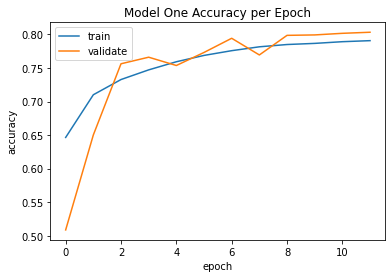

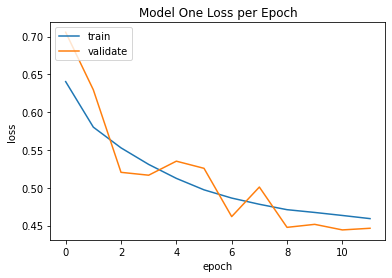

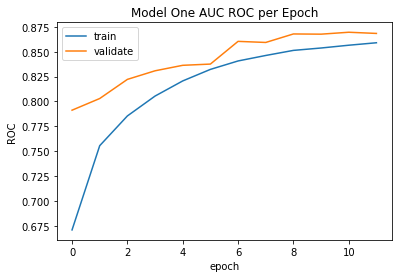

In [20]:
# compare train vs test accuracy for number of epochs
plt.plot(history_model1.history['accuracy'])
plt.plot(history_model1.history['val_accuracy'])
plt.title('Model One Accuracy per Epoch')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# compare train vs test loss for number of epochs
plt.plot(history_model1.history['loss'])
plt.plot(history_model1.history['val_loss'])
plt.title('Model One Loss per Epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# compare train vs test AUC for number of epochs
plt.plot(history_model1.history['auc'])
plt.plot(history_model1.history['val_auc'])
plt.title('Model One AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [21]:
# with the 2nd model, I am using hyperparameters and optimizer(s)
ROC2 = tf.keras.metrics.AUC()

with strategy.scope():
    
    #build first model
    model2 = Sequential()
    
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu', ))
    model2.add(Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
    model2.add(MaxPooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.2))
    
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(AveragePooling2D(pool_size=(2,2)))
    model2.add(Dropout(0.2))
    
    model2.add(BatchNormalization())
    model2.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu'))
    model2.add(Flatten())
    model2.add(Dense(1, activation='sigmoid'))
    
    #manually building my model using batch input shape
    model2.build(input_shape=(BATCH_SIZE, 64, 64, 3))
    
    #configure the learning process for my model
    SGD_optimizer = SGD(learning_rate=0.001, momentum = 0.8)
    model2.compile(loss='binary_crossentropy', metrics=['accuracy', ROC2], optimizer=SGD_optimizer)
    
#summary function allows me to view the layer, output shape, and number of parameters
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (512, 62, 62, 16)         448       
_________________________________________________________________
conv2d_5 (Conv2D)            (512, 60, 60, 16)         2320      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (512, 30, 30, 16)         0         
_________________________________________________________________
dropout (Dropout)            (512, 30, 30, 16)         0         
_________________________________________________________________
batch_normalization (BatchNo (512, 30, 30, 16)         64        
_________________________________________________________________
conv2d_6 (Conv2D)            (512, 28, 28, 32)         4640      
_________________________________________________________________
conv2d_7 (Conv2D)            (512, 26, 26, 32)        

In [22]:
EPOCHS = 12

# fit_generator is used to train our deep learning model
history_model2 = model2.fit_generator(
                        train_data,
                        epochs = EPOCHS,
                        validation_data = valid_data)

Epoch 1/12
366/366 [==============================] - 292s 792ms/step - loss: 0.5105 - accuracy: 0.7554 - auc_1: 0.8229 - val_loss: 1.6266 - val_accuracy: 0.4401 - val_auc_1: 0.8259
Epoch 2/12
366/366 [==============================] - 298s 814ms/step - loss: 0.4465 - accuracy: 0.7997 - auc_1: 0.8675 - val_loss: 0.5237 - val_accuracy: 0.7673 - val_auc_1: 0.8499
Epoch 3/12
366/366 [==============================] - 298s 815ms/step - loss: 0.4161 - accuracy: 0.8174 - auc_1: 0.8843 - val_loss: 0.8613 - val_accuracy: 0.6768 - val_auc_1: 0.8928
Epoch 5/12
366/366 [==============================] - 292s 797ms/step - loss: 0.4061 - accuracy: 0.8223 - auc_1: 0.8902 - val_loss: 1.0764 - val_accuracy: 0.6305 - val_auc_1: 0.8879
Epoch 6/12
366/366 [==============================] - 288s 786ms/step - loss: 0.4003 - accuracy: 0.8257 - auc_1: 0.8934 - val_loss: 0.6191 - val_accuracy: 0.7670 - val_auc_1: 0.8897
Epoch 7/12
366/366 [==============================] - 297s 811ms/step - loss: 0.3941 - acc

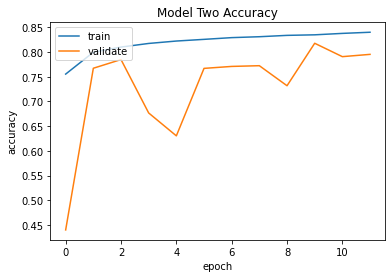

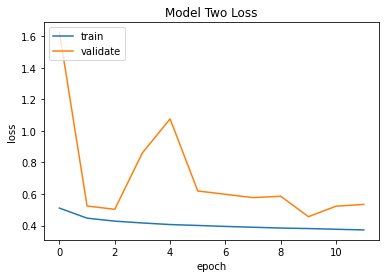

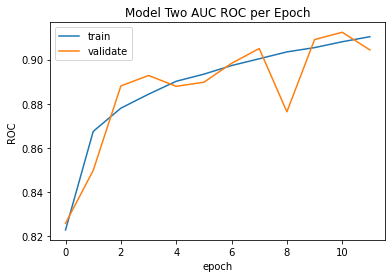

In [24]:
# compare train vs test accuracy for number of epochs
plt.plot(history_model2.history['accuracy'])
plt.plot(history_model2.history['val_accuracy'])
plt.title('Model Two Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# compare train vs test loss for number of epochs
plt.plot(history_model2.history['loss'])
plt.plot(history_model2.history['val_loss'])
plt.title('Model Two Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

# compare train vs test AUC for number of epochs
plt.plot(history_model2.history['auc_1'])
plt.plot(history_model2.history['val_auc_1'])
plt.title('Model Two AUC ROC per Epoch')
plt.ylabel('ROC')
plt.xlabel('epoch')
plt.legend(['train', 'validate'], loc='upper left')
plt.show();

In [25]:
#build a dataframe just containing ids, then we will add predictions
df_test = pd.DataFrame({'id':os.listdir(test_path)})
df_test.head()

,id
0,a7ea26360815d8492433b14cd8318607bcf99d9e.tif
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif


In [26]:
# using 1/255 for the rescale value because 255 is the maximum pixel value and so we want our new values to be between 0 and 1
# just like I did for the train data
idg_test = ImageDataGenerator(rescale=1./255.)

test_data = idg_test.flow_from_dataframe(
    dataframe=df_test,
    directory=test_path,
    x_col='id', 
    y_col=None,
    target_size=(64,64),
    batch_size=1,
    shuffle=False,
    class_mode=None)

Found 57458 validated image filenames.


In [27]:
#using model with hyperparameters, create predictions
pred = model2.predict(test_data, verbose=1) # verbose = 1 will show me a progress bar as predictions are being created

57458/57458 [==============================] - 439s 8ms/step


In [28]:
#combine dataframe with just ids with predictions to create submission dataframe
pred = np.transpose(pred)[0]
submission = pd.DataFrame()
submission['id'] = df_test['id'].apply(lambda x: x.split('.')[0])
submission['label'] = list(map(lambda x: 0 if x < 0.5 else 1, pred))
submission.head()

,id,label
0,a7ea26360815d8492433b14cd8318607bcf99d9e,1
1,59d21133c845dff1ebc7a0c7cf40c145ea9e9664,0
2,5fde41ce8c6048a5c2f38eca12d6528fa312cdbb,0
3,bd953a3b1db1f7041ee95ff482594c4f46c73ed0,1
4,523fc2efd7aba53e597ab0f69cc2cbded7a6ce62,1


In [29]:
#view the distribution of test prediction counts
submission['label'].value_counts()

1    29615
0    27843
Name: label, dtype: int64

In [30]:
#convert dataframe to csv for the competition
submission.to_csv('submission.csv', index=False)

# Step 4: Results and Analysis

When looking at the 3 charts for Accuracy, Loss and AUC, for the model with hyperparameters, I don’t see a smooth curve when looking at the validate data set.  But over time after 12 epochs, there was substantial improvement from the 1st epoch.

As expected, the second model with hyperparameters performed much better than the first model without them.  For example, when looking at the charts, the train data showed, after 12 epochs, Accuracy improved from 0.7908 to 0.8401.  Loss improved from 0.4592 to 0.3720.  AUC improved from 0.8590 to 0.9104.

I also found that the models trained better when I switched from using 8 to 12 epochs.

# Step 5: Conclusion

There are a lot of hyperparameters that could be changed to improve Accuracy, Loss and AUC.  I could have also switched from SGD to Adam optimizer.  But I was satisfied when I saw Accuracy, Loss and AUC improved after the hyperparameters I chose.